# Cloud Type Determination by Altitude for Analyzing Cloud Radiative Effects

Production date: 23-10-2024, modified 12-06-2025

Produced by: CNRS


## 🌍 Use case: Intercomparison of cloud top altitude distributions from satellite retrievals

## ❓ Quality assessment question:
 - __How does cloud top pressure vary between climate zones, and which dataset provides the most realistic distribution?__



Clouds are fundamental regulators of the Earth's climate system, significantly influencing the planet's radiative budget, hydrological cycle, and global circulation. These factors, in turn, play a crucial role in shaping ecosystems, agriculture, water resources, and weather patterns. The overall impact of clouds on Earth's climate is determined by various properties, including cloud height, amount, thickness, and microphysical characteristics. Given their substantial influence on climate, cloud properties are extensively studied, both in the present context and in relation to their evolution under climate change.
The following notebook focuses on the cloud height.

High and low clouds have distinct atmospheric radiative effects due to differences in temperature, thickness, and composition. High clouds strongly trap outgoing longwave infrared radiation from the Earth's surface, and they allow most shortwave solar radiation to pass when they are thin. This leads to a net warming effect on both the surface and the atmosphere. In contrast, low clouds reflect a significant portion of incoming solar radiation back into space, producing a cooling effect.

This analysis utilizes cloud observations from the dataset [__Cloud properties global gridded monthly and daily data from 1979 to present derived from satellite observations__](https://cds.climate.copernicus.eu/datasets/satellite-cloud-properties?tab=overview), available at the Climate Data Store. Two complementary Thematic Climate Data Records of cloud properties are provided from two families: CLARA (CM SAF cLoud, Albedo and surface Radiation) and CCI (Climate Change Initiative). These data differ in temporal sampling and horizontal resolution, and three distinct products are available: The two retrieval versions, CLARA-A2 and CLARA-A3, use AVHRR (Advanced Very High Resolution Radiometer) observations, while the CCI product is derived from ATSR2 (Along Track Scanning Radiometer) and AATSR (Advanced ATSR), only covering the period 1995-2012. A CCI intermediate climate data record is available from 2017 onwards, using SLSTR (Sea and Land Surface Temperature Radiometer). The latter is not yet homogenized with the earlier data. Therefore, it is not used in this analysis.

CLARA-A2, CLARA-A3, and CCI, use different methods to retrieve cloud properties. This notebook presents a comparative analysis of their cloud top pressure estimates, both among themselves and against other satellite data [[1]](https://link.springer.com/article/10.1007/s10712-024-09824-0). These datasets also provide cloud top temperature and altitude. This analysis focuses on cloud-top pressure, as it is directly retrieved. The other variables are derived from cloud top pressure by using atmospheric profiles, obtained from meteorological reanalyses.




## 📢 Quality assessment statement 

It is important to note that passive remote sensing has limitations: it provides a top-down perspective, which does not account for hidden cloud layers, and it estimates a 'radiative' cloud height. This radiative height can be several kilometers below the actual cloud top, especially in cases where clouds have diffuse tops, with optical depth gradually increasing from the top down over a significant vertical range. This phenomenon is relevant for approximately 70% of high clouds in the tropics and 30-40% of high clouds in the midlatitudes [[2]](https://doi.org/10.1029/94JD02430).

```{admonition} These are the key outcomes of this assessment
:class: note

- All datasets show more low-level clouds over ocean than over land, as expected.

- The CCI dataset produces by far the least realistic cloud top height distributions among the evaluated products, by strongly underestimating the amount of high-level clouds (no peak in the upper troposphere). Since the channels of the AATSR and AVHRR instruments are similar, the reason lies in the retrieval method, based on optimal estimation and the assumption of a single layer cloud. The retrieved cloud top pressure is an effective one, defined by infrared radiation. In the case of semi-transparent cirrus, this height should lie much below the cloud top, depending on the optical depth of the cloud. Furthermore, during daytime, the combined use of infrared and visible radiances may lead to a cloud height underestimation due to underlying lower cloud layers.

- The two retrieval versions of the CLARA product lead to very different results. While the A2 version uses a classical retrieval approach, based on radiative transfer, the A3 version uses a neural network approach trained with active lidar data from CALIPSO. This leads to retrievals of 'radiative' cloud height for CLARA-A2 and cloud top height for CLARA-A3. However, the CLARA-A3 product seems to identify also very thin (sub-visible) cirrus clouds above the tropopause layer, which a passive sensor like AVHRR should not be able to detect, in particular stratospheric clouds in polar regions over land.

- The CLARA-A2 cloud top pressure of high clouds peaks in the tropics at about 250 hPa. Towards higher latitudes, this peak moves towards larger pressure (lower height). The distributions are bimodal over tropical ocean and in the subtropics. The height of low-level clouds over ocean may be slightly overestimated (800 instead of 850 hPa).

- Compared to CLARA-A2, the CLARA-A3 cloud top pressure peaks around 800 hPa are slightly narrower, while the peaks in the upper troposphere are much more pronounced and at a much higher altitude (150 hPa to 220 hPa in the tropics and subtropics). Yet, at polar latitudes, the CLARA-A3 distributions have still only a single peak in the middle troposphere, and over polar land a non-negligible amount of clouds above the tropopause.

- According to the description in the files, CCI only provides an effective cloud top defined by IR radiation. This height may considerably underestimate the real cloud height. However, the daytime uncertainty of cloud top pressure is quite small. Is is interesting to note that the night uncertainty of high and low-level clouds is similar, but larger than the daytime uncertainty, although the distributions over ocean are similar during day- and nighttime.

- While CLARA-A2 does not provide uncertainty estimates, the uncertainty distributions of CLARA-A3 peak around 20 hPa over the whole globe, with broader distributions for low-level clouds than for high-level clouds and a secondary peak around 100 hPa over land, which is due to gridboxes with only a few cloudy observations.
```


## 📋 Methodology

The analysis comprises the following steps:

**[](section:parameters)**
 * Import the relevant libraries. Define the parameters of the analysis and set the dataset requests.

**[](section:download)**
 * Download the satellite products of daily mean cloud top pressure and its uncertainty.
 * Check the quality status of the CLARA-A3 data.

**[](section:results)**
 * Prepare the datasets for the analysis, selecting four different latitude bands
 * Include the land mask into the datasets and include climatological limits of the tropopause for the different latitude bands
 * Plot the cloud top pressure distributions for selected latitude bands, separately over ocean and over land
 * Plot the cloud top pressure uncertainty distribution for the daytime observation of the CCI product
 * Plot the cloud top pressure uncertainty distributions for CLARA-A3 and CCI nighttime observations separately for the selected latitude bands

## 📈 Analysis and results

(section:parameters)=
### Choose the parameters to use and setup code

This section includes the library imports and the parameter settings for the analysis.

#### Import libraries

In [1]:
import collections

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import regionmask
import xarray as xr
import xhistogram
from c3s_eqc_automatic_quality_control import download, utils

plt.style.use("seaborn-v0_8-notebook")

#### Set parameters

In [2]:
# Time
start = "2011-01"
stop = "2011-12"

# Latitude
latitude_slices = {
    "deep-tropics": [slice(-10, 10)],
    "sub-tropics": [slice(-30, -10), slice(10, 30)],
    "mid-latitudes": [slice(-60, -30), slice(30, 60)],
    "polar": [slice(-80, -60), slice(60, 80)],
}
assert all([isinstance(v, list) for k, v in latitude_slices.items()])

# Plot kwargs
plot_kwargs = {
    "CCI day": {"color": "dodgerblue", "ls": "--"},
    "CCI night": {"color": "darkblue", "ls": ":"},
    "CLARA-A2": {"color": "orange", "ls": "-"},
    "CLARA-A3": {"color": "red", "ls": "-"},
}

(section:download)=
### Download the data and check quality

#### Define request

In [3]:
collection_id = "satellite-cloud-properties"
request_clara = {
    "origin": "eumetsat",
    "variable": ["cloud_top_level"],
    "climate_data_record_type": "thematic_climate_data_record",
    "time_aggregation": "daily_mean",
}
requests = {
    "CCI": {
        "product_family": "cci",
        "time_aggregation": "daily_mean",
        "climate_data_record_type": "thematic_climate_data_record",
        "sensor_on_satellite": "aatsr_on_envisat",
        "variable": "all_variables",
        "origin": "esa",
    },
    "CLARA-A2": request_clara | {"product_family": "clara_a2"},
    "CLARA-A3": request_clara | {"product_family": "clara_a3"},
}
requests = {
    product: download.update_request_date(request, start, stop, stringify_dates=True)
    for product, request in requests.items()
}

chunks = {"year": 1, "month": 1}

#### Functions to cache

In [4]:
def preprocess(ds):
    time = pd.to_datetime(ds.attrs["time_coverage_start"].replace("Z", ""))
    return ds.assign_coords(time=[time])


def get_variables(ds, variables):
    return ds[variables]


def mask_and_regionalise(ds, lat_slices):
    if (record_status := ds.get("record_status")) is not None:
        ds = ds.where((record_status == 0).compute(), drop=True)

    ds = xr.combine_by_coords(
        [
            utils.regionalise(ds, lon_slice=slice(-180, 180), lat_slice=lat_slice)
            for lat_slice in lat_slices
        ]
    )

    lsm = regionmask.defined_regions.natural_earth_v5_0_0.land_110
    lsm = lsm.mask_3D(ds).squeeze("region", drop=True)
    return xr.concat(
        [
            ds.where(lsm).expand_dims(mask=["land"]),
            ds.where(~lsm).expand_dims(mask=["ocean"]),
        ],
        "mask",
    )


def compute_cloud_top_distribution(ds, lat_slices):
    ds = mask_and_regionalise(ds, lat_slices)
    dataarrays = []
    for var, da in ds.data_vars.items():
        if not var.startswith("ctp"):
            continue
        n_bins = 50
        da = xhistogram.xarray.histogram(
            da,
            bins=np.linspace(0, 1_000, n_bins + 1),
            dim=["time", "latitude", "longitude"],
        )
        da = da.rename(var, **{f"{var}_bin": "bin"})
        da = da / da.sum("bin") * n_bins / 10
        da.attrs = {"long_name": "Normalized Density", "units": "hPa$^{-1}$"}
        dataarrays.append(da)
    da = xr.merge(dataarrays)
    da["bin"].attrs = {"long_name": "Cloud Top Pressure", "units": "hPa"}
    return da


def compute_cloud_top_density(ds):
    dataarrays = []
    for var, da in ds.data_vars.items():
        if not var.startswith("ctp"):
            continue
        da = xhistogram.xarray.histogram(da, density=True, bins=np.arange(0, 1_011))
        da = da.rename(var, **{f"{var}_bin": "bin"})
        da.attrs = {"long_name": "Density", "units": "hPa$^{-1}$"}
        dataarrays.append(da)
    da = xr.merge(dataarrays)
    da["bin"].attrs = {"long_name": "Cloud Top Pressure", "units": "hPa"}
    return da


def unc_distribution(ctp, unc):
    da = xr.concat(
        [
            unc.where(ctp > 700).expand_dims(clouds=["low"]),
            unc.where(ctp < 200).expand_dims(clouds=["high"]),
        ],
        "clouds",
    )
    n_bins = 50
    da = xhistogram.xarray.histogram(
        da, bins=np.linspace(0, 150, n_bins + 1), dim=["time", "latitude", "longitude"]
    )
    da = da.rename(unc.name, **{f"{unc.name}_bin": "bin"})
    da = da / da.sum("bin") * 100
    da["bin"].attrs = {"long_name": "Cloud top pressure uncertainty"}
    da.attrs = {"long_name": "Density", "units": "%"}
    return da


def compute_uncertainty_distribution(ds, lat_slices):
    ds = mask_and_regionalise(ds, lat_slices)
    dataarrays = []
    if "ctp" in ds:
        dataarrays.append(unc_distribution(ds["ctp"], ds["ctp_unc01"]))
    else:
        for prefix in ("day", "night"):
            for suffix in ("unc"):
                dataarrays.append(
                    unc_distribution(ds[f"ctp_{prefix}"], ds[f"ctp_{prefix}_{suffix}"])
                )
    assert dataarrays
    return xr.merge(dataarrays)

#### Show CLARA-A3 quality

In [5]:
ds = download.download_and_transform(
    collection_id,
    requests["CLARA-A3"],
    preprocess=preprocess,
    chunks=chunks,
    transform_chunks=False,
    transform_func=get_variables,
    transform_func_kwargs={"variables": ["record_status"]},
)
da = ds["record_status"]
for status in [0, 1, 2]:
    print(f"Number of records with status {status}: ", (da == status).sum().values)

Number of records with status 0:  365
Number of records with status 1:  0
Number of records with status 2:  0


#### Download and transform

In [6]:
distributions = collections.defaultdict(list)
for product, request in requests.items():
    for region, lat_slices in latitude_slices.items():
        print(f"{product=} {region=}")
        ds = download.download_and_transform(
            collection_id,
            request,
            preprocess=preprocess,
            chunks=chunks,
            transform_chunks=False,
            transform_func=compute_cloud_top_distribution,
            transform_func_kwargs={"lat_slices": lat_slices},
        )
        distributions[product].append(ds.expand_dims(region=[region]))
distributions = {
    key: xr.concat(values, "region") for key, values in distributions.items()
}

product='CCI' region='deep-tropics'
product='CCI' region='sub-tropics'
product='CCI' region='mid-latitudes'
product='CCI' region='polar'
product='CLARA-A2' region='deep-tropics'
product='CLARA-A2' region='sub-tropics'
product='CLARA-A2' region='mid-latitudes'
product='CLARA-A2' region='polar'
product='CLARA-A3' region='deep-tropics'
product='CLARA-A3' region='sub-tropics'
product='CLARA-A3' region='mid-latitudes'
product='CLARA-A3' region='polar'


In [7]:
uncertanties = collections.defaultdict(list)
for product, request in requests.items():
    if product == "CLARA-A2":
        continue
    for region, lat_slices in latitude_slices.items():
        print(f"{product=} {region=}")
        ds = download.download_and_transform(
            collection_id,
            request,
            preprocess=preprocess,
            chunks=chunks,
            transform_chunks=False,
            transform_func=compute_uncertainty_distribution,
            transform_func_kwargs={"lat_slices": lat_slices},
        )
        uncertanties[product].append(ds.expand_dims(region=[region]))
uncertanties = {
    key: xr.concat(values, "region") for key, values in uncertanties.items()
}

product='CCI' region='deep-tropics'
product='CCI' region='sub-tropics'
product='CCI' region='mid-latitudes'
product='CCI' region='polar'
product='CLARA-A3' region='deep-tropics'
product='CLARA-A3' region='sub-tropics'
product='CLARA-A3' region='mid-latitudes'
product='CLARA-A3' region='polar'


(section:results)=
### Results

#### Cloud top pressure

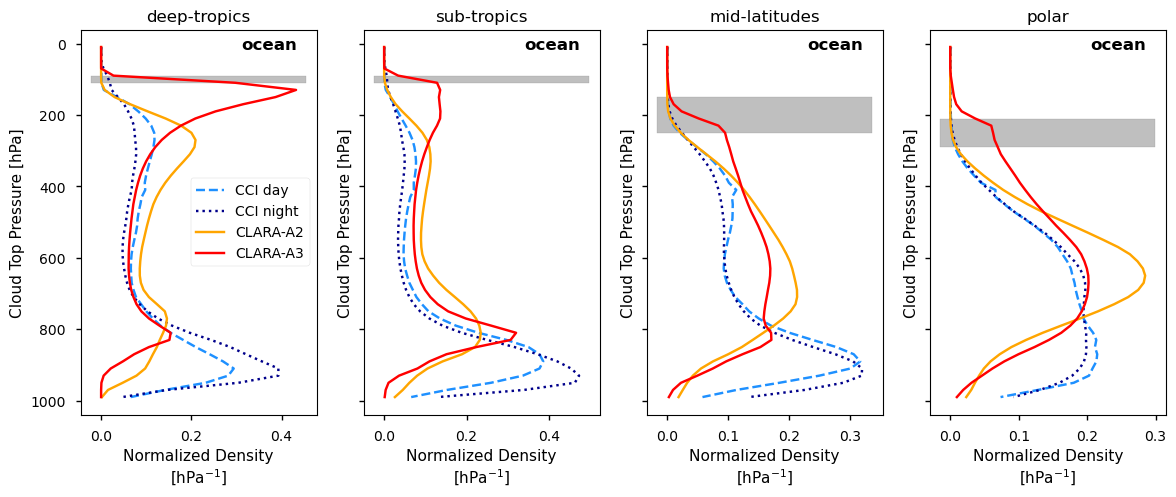

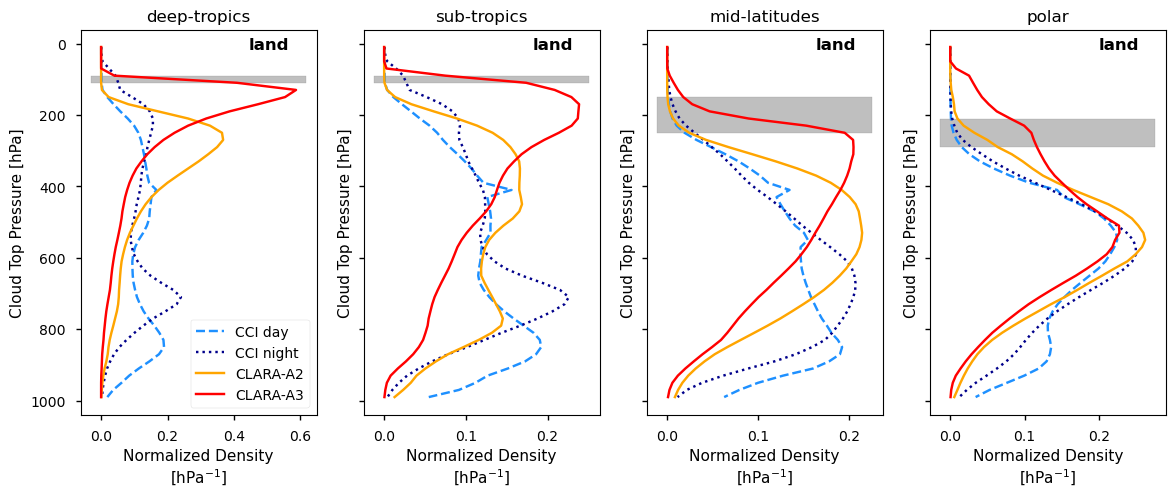

In [8]:
tropopause_level = {
    "deep-tropics": {"level": 100, "width": 10},
    "sub-tropics": {"level": 100, "width": 10},
    "mid-latitudes": {"level": 200, "width": 50},
    "polar": {"level": 250, "width": 40},
}

for mask in ["ocean", "land"]:
    fig, axs = plt.subplots(1, len(latitude_slices), figsize=(14, 5), sharey=True)
    for ax, region in zip(axs, list(latitude_slices)):
        for product, ds in distributions.items():
            for suffix in ("", "day", "night"):
                name = f"ctp_{suffix}" if suffix else "ctp"
                if name not in ds:
                    continue
                da = ds[name].sel(mask=mask, region=region)
                label = f"{product} {suffix}" if suffix else product
                da.plot(
                    ax=ax, y="bin", yincrease=False, label=label, **plot_kwargs[label]
                )
        # Add level
        level = tropopause_level[region]["level"]
        width = tropopause_level[region]["width"]
        ax.fill_between(
            ax.get_xlim(),
            [level - width] * 2,
            [level + width] * 2,
            color="gray",
            alpha=0.5,
        )
        # Labels
        ax.set_title(region)
        ax.text(
            0.8,
            0.96,
            mask,
            transform=ax.transAxes,
            fontsize=12,
            weight="bold",
            ha="center",
            va="center",
        )
    axs[0].legend()

_**Figure caption:** Normalized cloud top pressure distributions over ocean (top) and over land (bottom), separately for deep-tropics, sub-tropics, mid-latitudes and polar regions during the period of interest. Compared are results derived from CLARA-A2, CLARA-A3 and CCI (day and night). Tropopause levels (depending on season) are shown as gray bands. The tropopause shifts from about 100 hPa (~17 km) in the tropics to 250 hPa (~9 km) in the polar regions._

The figure above compares normalized cloud top pressure distributions derived from CLARA-A2, CLARA-A3 and CCI (day and night). These normalized distributions provide a view from above, without accounting for hidden cloud layers beneath the top layer. While several features are consistent across the three datasets, others show notable differences. In the following, these distributions are compared with the results from the GEWEX cloud assessment [[1]](https://link.springer.com/article/10.1007/s10712-024-09824-0) to estimate which dataset offers the most realistic representation.

The GEWEX cloud assessment indicates that cloud top pressure distributions over oceans exhibit a bimodal pattern in tropical regions, with pronounced peaks in the upper and lower troposphere. These strong peaks decrease in intensity as one moves toward the polar regions. Over land, the contribution of single-layer low-level clouds is minimal. Moreover, the cloud tops of high clouds are high in the tropics and gradually lower toward the poles following the tropopause.

The CLARA-A2 dataset correctly captures two distinct peaks in cloud density over tropical oceans, corresponding to high and low cloud layers. These peaks converge into the mid-troposphere as they approach polar regions. Over land, the cloud density peaks at high altitudes in the tropics, with this peak becoming broader and shifting to lower altitudes toward the poles. The updated GEWEX cloud assessment includes several cloud datasets
provided by the Cloud-Aerosol Lidar and Infrared Pathfinder Satellite Observation (CALIPSO) Science Team [[5]](https://doi.org/10.5194/amt-12-703-2019), one mimicking the sensitivity of passive remote sensing [[1]](https://link.springer.com/article/10.1007/s10712-024-09824-0). With respect to this dataset (CALIPSO-passive), the height of low-level clouds given by CLARA-A2 is slightly overestimated (800 instead of 850 hPa), while the height of high-level clouds is underestimated. The latter is expected, since the active
lidar of CALIPSO determines the cloud top, while a classical cloud retrieval using (passive) radiometers, yields a 'radiative' cloud height, which is below the cloud top, in particular for diffuse cloud tops which are frequent in the tropics [[2]](https://doi.org/10.1029/94JD02430). It should be noted that the CLARA-A2 version displayed in [[1]](https://link.springer.com/article/10.1007/s10712-024-09824-0) is an earlier version than the one provided in the CDS (versions 2.0 and 2.1, respectively).

The CLARA-A3 dataset also depicts two distinct peaks in cloud density over tropical oceans, associated with high and low clouds. These peaks are more pronounced and narrower, particularly in the high troposphere. Over land, CLARA-A3 shows a significant peak of high clouds in the tropics, which becomes less prominent at polar latitudes as the mid-level cloud presence increases. The cloud top pressure retrieval for CLARA-A3 is based on a neural network trained on CALIPSO cloud data. Consequently, the CLARA-A3 product also includes very thin cirrus clouds in the tropopause layer, which a passive sensor like AVHRR is not able to detect, in particular stratospheric clouds in polar regions over frozen land. Compared to CALIPSO results in [[1]](https://link.springer.com/article/10.1007/s10712-024-09824-0), low-level clouds over ocean have slightly higher cloud tops (800 instead of 850 hPa), as CLARA-A2, but the peaks are narrower than for CLARA-A2.

The CCI product only provides cloud top pressure data separately for daytime and nighttime. Both provide similar distributions over ocean, with slightly less high and more low clouds during nighttime. Over land during nighttime the distributions reveal slightly more high clouds and the peak of low-level clouds is shifted to about 700 hPa, compared to 900 hPa during daytime. Furthermore, the distributions of cloud top pressure differ significantly from those of the CLARA products and those deduced from similar instruments as shown in Figure 6 of [[1]](https://link.springer.com/article/10.1007/s10712-024-09824-0). The CCI product overestimates the relative occurrence of low clouds and strongly underestimates the relative occurrence of high clouds, both over land and ocean, especially over tropical and mid-latitude regions. In particular, the expected high-altitude peak in the tropics is nearly negligible. Overall, these cloud top pressure distributions are the least realistic among the products evaluated.


#### Cloud top pressure uncertainty

In this subsection, we investigate the uncertainty estimates for cloud top pressure, provided by CCI and CLARA-A3. Since CCI dataset provides cloud top pressure and its associated uncertainty separately for daytime and nighttime, we explore both separately.

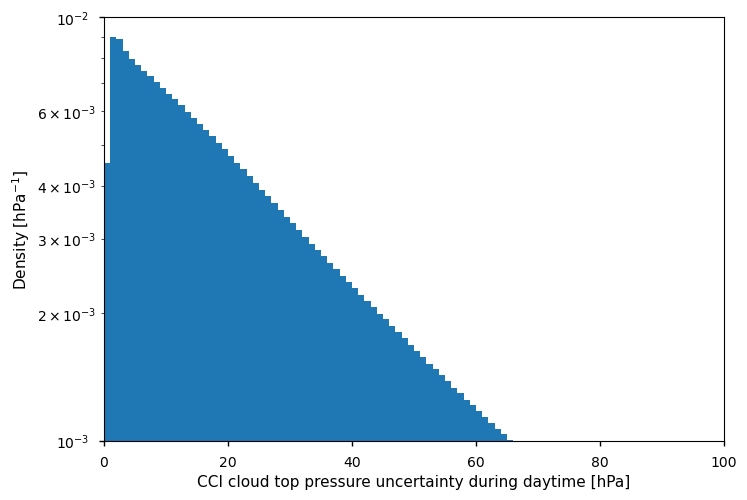

In [9]:
ds = download.download_and_transform(
    collection_id,
    requests["CCI"],
    chunks=chunks,
    preprocess=preprocess,
    transform_chunks=False,
    transform_func=compute_cloud_top_density,
)
da = ds["ctp_day_cor"]
plt.bar(da["bin"], da, width=1)
plt.ylim(0.001, 0.01)
plt.xlim(0, 100)
plt.yscale("log")
plt.xlabel("CCI cloud top pressure uncertainty during daytime [hPa]")
_ = plt.ylabel("Density [hPa$^{-1}$]")

_**Figure caption:** Distribution of cloud top pressure uncertainty during daytime provided by the CCI product._

The distribution of CCI daytime cloud top pressure uncertainty has a peak close to 0, with largest values around 60 hPa. This uncertainty is obtained by the Optimal Estimation Method, which in this retrieval assumes single layered clouds, and may be therefore underestimated due to multi-layered cloud situations, in particular in the case of semi-transparent cirrus clouds above low-level clouds.

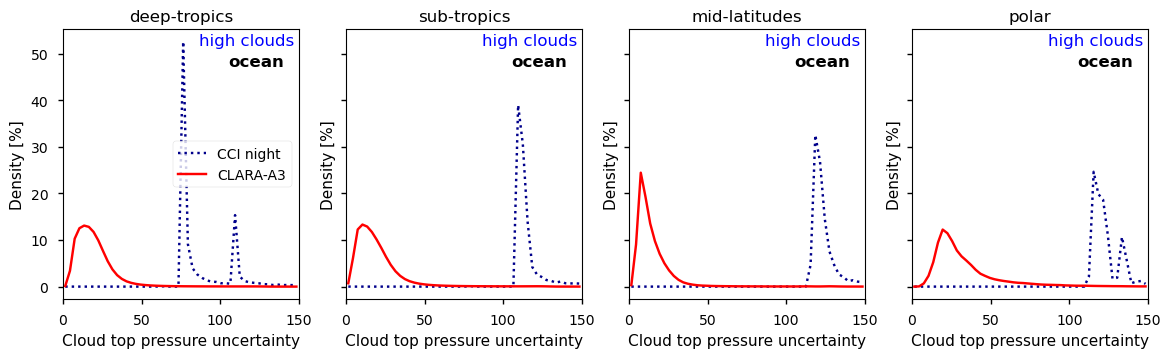

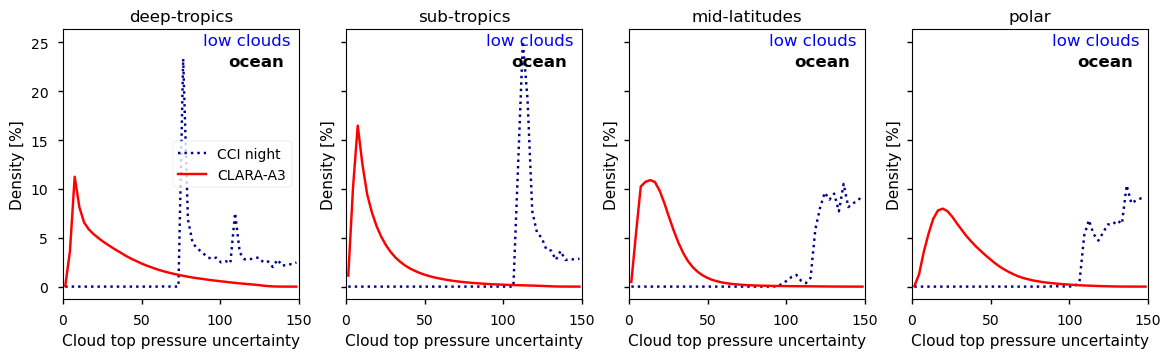

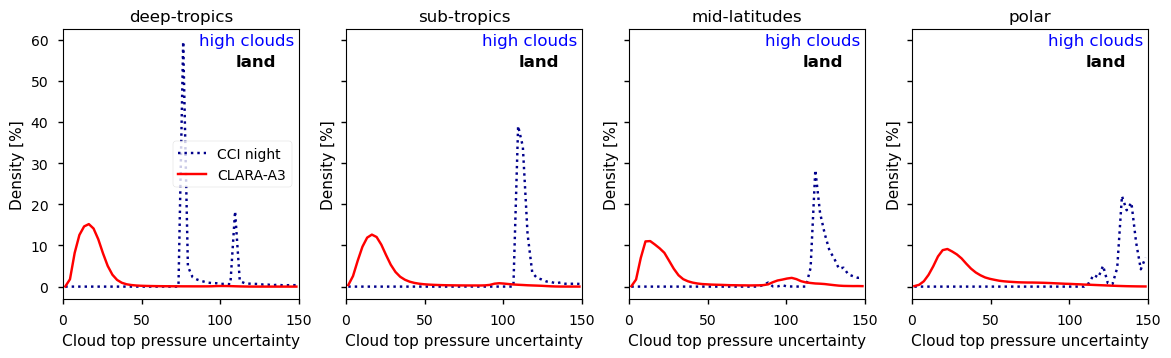

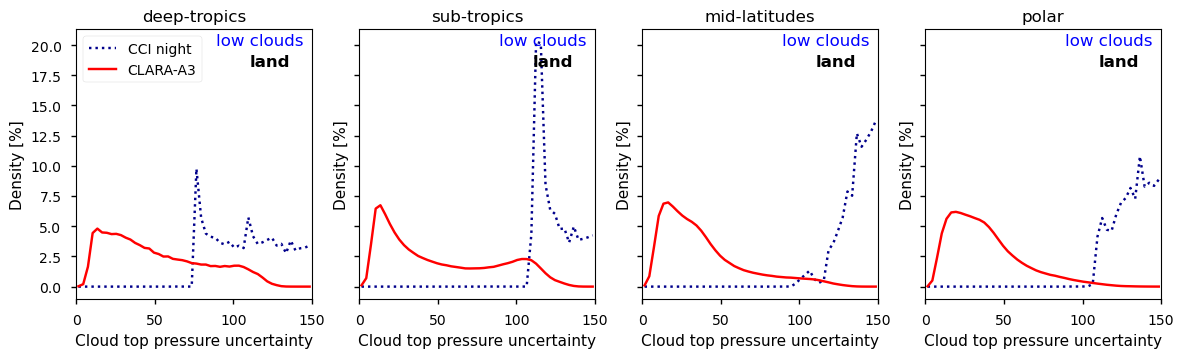

In [10]:
for mask in ["ocean", "land"]:
    for clouds in ["high", "low"]:
        fig, axs = plt.subplots(1, len(latitude_slices), figsize=(14, 3.5), sharey=True)
        for ax, region in zip(axs, list(latitude_slices)):
            for product, ds in uncertanties.items():
                label = product
                match product:
                    case "CCI":
                        name = "ctp_night_unc"  # Alternative: "ctp_night_cor"
                        label += " night"
                    case "CLARA-A3":
                        name = "ctp_unc01"
                    case _:
                        raise NotImplementedError(f"{product=}")

                da = ds[name].sel(mask=mask, region=region, clouds=clouds)
                da.plot(ax=ax, x="bin", label=label, **plot_kwargs[label])
            # Labels
            ax.set_title(region)
            ax.set_xlim(0,150)
            ax.text(
                0.82,
                0.88,
                mask,
                transform=ax.transAxes,
                fontsize=12,
                weight="bold",
                ha="center",
                va="center",
            )
            ax.text(
                0.78,
                0.96,
                clouds + " clouds",
                transform=ax.transAxes,
                fontsize=12,
                color="b",
                ha="center",
                va="center",
            )
            axs[0].legend()

_**Figure caption:** Distribution of cloud top pressure uncertainty over land for high (top) and low clouds (bottom), in the by deep tropics, subtropics, mid-latitudes, and polar regions during the period of interest. The red line represents the CLARA-A3 dataset, while the light blue dotted lines indicate CCI nighttime data._

The CLARA-A3 distributions of cloud top pressure uncertainty have a peak between 10 and 20 hPa. Over the ocean, uncertainties above 50 hPa are negligible. However, over land, a secondary peak occurs around 100 hPa, which is attributed to gridboxes with only a few cloudy observations (not shown). It is interesting to note that the uncertainty of high-level cloud top pressure is smallest in the midlatitudes. Furthermore, the uncertainty for low-level clouds over land is largest.

While the CCI cloud top pressure uncertainty distribution during daytime is in a similar range as the one of CLARA-A3, the CCI distributions during nighttime start only at values larger than 75 or even 100 hPa and reach values up to 150 hPa. This may be understandable for clouds over land in general, as the CCI cloud top pressure of low-level clouds is around 700 hPa during nighttime (compared to 900 hPa during daytime) and the peak in high-level clouds is even smaller than during daytime. However, over ocean, the distributions are much more similar during day-and nighttime, so one would expect similar uncertainties. 

## ℹ️ If you want to know more
### Key resources
Some key resources and further reading were linked throughout this assessment.

The CDS catalogue entry for the data used is:
- Cloud properties global gridded monthly and daily data from 1979 to present derived from satellite observations:
https://cds.climate.copernicus.eu/datasets/satellite-cloud-properties?tab=overview

Code libraries used:
- [C3S EQC custom functions](https://github.com/bopen/c3s-eqc-automatic-quality-control/tree/main/c3s_eqc_automatic_quality_control), `c3s_eqc_automatic_quality_control`, prepared by [B-Open](https://www.bopen.eu/)


The GEWEX Cloud Assessment:
- The Global Energy and Water Exchanges (GEWEX) program is a core project of the World Climate Research Programme (WCRP). The first GEWEX Cloud Assessment was published in 2012 and it provided the first coordinated inter-comparison of publicly available, global
cloud products [[3](https://doi.org/10.1175/BAMS-D-12-00117.1)-[4](https://www.wcrp-climate.org/documents/GEWEX_Cloud_Assessment_2012.pdf)]. The database associated with the GEWEX Cloud Assessment
has revealed its usefulness for the assessment of new datasets. Since in the last decade existing
cloud property retrievals have been revised and new retrievals have been developed, this exercise has been recently repeated with 11 global cloud products derived from measurements of multi-spectral imagers, IR sounders, and lidar [[1]](https://link.springer.com/article/10.1007/s10712-024-09824-0). The first cloud assessment included products from ATSR, while the most recent assessment includes CLARA-A2. However, the CLARA-A2 version (V2.1) in the CDS is a later, improved version compared to the one provided in the updated GEWEX cloud assessment (V2.0). The updated cloud assessment database is available at [this link](https://gewexca.aeris-data.fr/).


### Reference/Useful material

[[1]](https://link.springer.com/article/10.1007/s10712-024-09824-0) Stubenrauch, C.J., Kinne, S., Mandorli, G. et al. Lessons Learned from the Updated GEWEX Cloud Assessment Database. Surv Geophys (2024). https://doi.org/10.1007/s10712-024-09824-0

[[2]](https://doi.org/10.1029/94JD02430) Liao, X., W. B. Rossow, and D. Rind (1995), Comparison between SAGE II and ISCCP high-level clouds: 2. Locating cloud tops, J. Geophys. Res., 100(D1), 1137–1147, doi:10.1029/94JD02430. 

[[3]](https://doi.org/10.1175/BAMS-D-12-00117.1) Stubenrauch, C. J., and Coauthors, 2013: Assessment of Global Cloud Datasets from Satellites: Project and Database Initiated by the GEWEX Radiation Panel. Bull. Amer. Meteor. Soc., 94, 1031–1049, https://doi.org/10.1175/BAMS-D-12-00117.1 

[[4]](https://www.wcrp-climate.org/documents/GEWEX_Cloud_Assessment_2012.pdf) Stubenrauch CJ, Rossow WB, Kinne S, GEWEX Cloud Assessment Team (2012) Assessment of Global Cloud Datasets from Satellites, A Project of the World Climate Research Programme Global Energy and Water Cycle Experiment (GEWEX) Radiation Panel, WCRP report.

[[5]](https://doi.org/10.5194/amt-12-703-2019) Liu Z, Kar J, Zeng S, Tackett J, Vaughan M, Avery M, Pelon J, Getzewich B, Lee K-P, Magill B, Omar A, Lucker P, Trepte C, Winker D (2019) Discriminating between clouds and aerosols in the CALIOP version 4.1 data products. Atmos Meas Tech 12:703–734. https://doi.org/10.5194/amt-12-703-2019